# Responsible AI - Project on algorithmic fairness

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
# TODO
# quantify which classes has the highest imbalance in roc curves (AUC) / using the provided metrics
# quantify the 3rd metric, find the difference between the distributions of probabilities

## Data import and summary statistics

In [55]:
# read data from csv file
df = pd.read_csv('data/catalan-juvenile-recidivism-subset.csv')

In [56]:
# set display max columns for pandas dataframe
pd.set_option('display.max_columns', 500)

In [57]:
df.head(10)

,id,V1_sex,V4_area_origin,V6_province,V8_age,V9_age_at_program_end,V11_criminal_record,V12_n_criminal_record,V13_n_crime_cat,V15_main_crime_cat,V16_violent_crime,V17_crime_classification,V19_committed_crime,V20_n_juvenile_records,V21_n_crime,V23_territory_of_execution,V24_finished_program,V26_finished_measure_grouped,V27_program_duration_cat,V28_days_from_crime_to_program,V29_program_duration,V115_RECID2015_recid,V10_date_of_birth_year,V10_date_of_birth_month,V22_main_crime_date_year,V22_main_crime_date_month,V30_program_start_year,V30_program_start_month,V31_program_end_month
0,691,male,Spain,Lleida,15,17,1,1-2,3+,Against People,1,1,Lesions,1.0,4,Lleida,Internament en centre,Internment,<6 months,587.0,132,1,1992,11,2008,8,2010,4,8
1,956,female,Spain,Barcelona,14,15,1,1-2,2,Against People,1,1,Lesions,1.0,2,Barcelona,Internament en centre,Internment,6 months < 1 year,107.0,258,1,1995,7,2009,8,2009,12,8
2,2560,male,Maghreb,Barcelona,15,16,1,3-5,3+,Against People,1,1,Lesions,4.0,3,Barcelona,Internament en centre,Internment,<6 months,135.0,85,1,1994,1,2009,11,2010,3,6
3,2018,male,Maghreb,Girona,14,15,1,5+,2,Against People,1,1,Lesions,7.0,2,Girona,Internament en centre,Internment,6 months < 1 year,176.0,271,1,1994,4,2009,1,2009,6,3
4,1650,male,Spain,Tarragona,17,20,1,5+,3+,Against People,1,1,Lesions,6.0,3,Tarragona,Internament en centre,Internment,>1 year,261.0,533,1,1990,9,2008,9,2009,5,11
5,4587,male,Spain,Barcelona,16,18,1,1-2,1,Against People,1,1,Lesions,1.0,1,Barcelona,Llibertat vigilada,Probation,6 months < 1 year,420.0,212,1,1992,4,2008,7,2009,9,4
6,1613,male,Spain,Barcelona,17,19,1,3-5,3+,Against People,1,0,Lesions,3.0,4,Barcelona,Llibertat vigilada,Probation,<6 months,547.0,118,1,1990,10,2008,9,2010,3,7
7,1132,male,Maghreb,Girona,14,16,1,5+,1,Against People,1,0,Lesions,7.0,1,Girona,Llibertat vigilada,Probation,6 months < 1 year,367.0,271,1,1994,1,2008,11,2009,11,8
8,925,male,Spain,Barcelona,17,19,1,5+,1,Against People,1,0,Lesions,6.0,1,Barcelona,Llibertat vigilada,Probation,6 months < 1 year,541.0,302,1,1990,8,2008,3,2009,9,7
9,1703,male,Maghreb,Barcelona,17,17,1,3-5,1,Against People,1,1,Lesions,4.0,1,Barcelona,Assessorament tècnic menors,ATM,<6 months,109.0,29,1,1992,11,2010,1,2010,5,6


In [58]:
df.columns, df.columns.shape

(Index(['id', 'V1_sex', 'V4_area_origin', 'V6_province', 'V8_age',
        'V9_age_at_program_end', 'V11_criminal_record', 'V12_n_criminal_record',
        'V13_n_crime_cat', 'V15_main_crime_cat', 'V16_violent_crime',
        'V17_crime_classification', 'V19_committed_crime',
        'V20_n_juvenile_records', 'V21_n_crime', 'V23_territory_of_execution',
        'V24_finished_program', 'V26_finished_measure_grouped',
        'V27_program_duration_cat', 'V28_days_from_crime_to_program',
        'V29_program_duration', 'V115_RECID2015_recid',
        'V10_date_of_birth_year', 'V10_date_of_birth_month',
        'V22_main_crime_date_year', 'V22_main_crime_date_month',
        'V30_program_start_year', 'V30_program_start_month',
        'V31_program_end_month'],
       dtype='object'),
 (29,))

### Encoding categorical data

In [59]:
# encoding categorical

# apply one hot encoding to categorical features
# TODO: one hot encode the numerical categorical values as well
#df = pd.get_dummies(df, columns=[col for col in df.columns if df[col].dtype == "object"])

# label encode columns with type "object"
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = le.fit_transform(df[col])


### Functions for plotting ROC curves

In [60]:
from sklearn import metrics

def plot_roc_curves(y_test, pred_proba, legend=""):
    fpr, tpr, _ = metrics.roc_curve(y_test, pred_proba)
    plt.plot(fpr, tpr, label=legend)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curve")
    plt.legend()

In [61]:
def plot_roc_curves_class(X_test, y_test, model, column):
    y_prob = pd.DataFrame(model.predict_proba(X_test))[1].values
    for class_ in X_test[column].unique():
        filter = (X_test[column] == class_)
        fpr, tpr, _ = metrics.roc_curve(y_test[filter], y_prob[filter])
        plt.plot(fpr, tpr, label=class_)
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title(f"ROC curve for {column}")
    plt.legend()

## Training

Split the dataset into training, validation and test sets, and train a machine
learning algorithm of your choice to predict the variable Recidivism

In [62]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [63]:
# Split features and target
X = df.drop(columns=["V115_RECID2015_recid", "id"])
y = df.V115_RECID2015_recid

In [64]:
# Split dataset into training set and test set  # 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

### Bootstrapping

In [65]:
# X_train["y"] = y_train
# filter_is_female = X_train.V1_sex_female == 1
# gender_diff = X_train.shape[0] - filter_is_female.sum()
# X_train = pd.concat((X_train[filter_is_female].sample(gender_diff, replace=True),X_train))
# y_train = X_train.y
# X_train = X_train.drop(columns = "y")
# # its half and half
# (X_train.V1_sex_female == 1).sum(), X_train.shape

### Define and fit model

In [66]:
# import sklearn random forest
from sklearn.ensemble import RandomForestClassifier

# Create Decision Tree classifer object
model = RandomForestClassifier(n_estimators=100)

# Train Decision Tree Classifer
model = model.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)


### Calculate accuracy

In [67]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7256446991404012


### Predict feature importance

In [68]:
# calculate sklearn permutation importance
from sklearn.inspection import permutation_importance
perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)


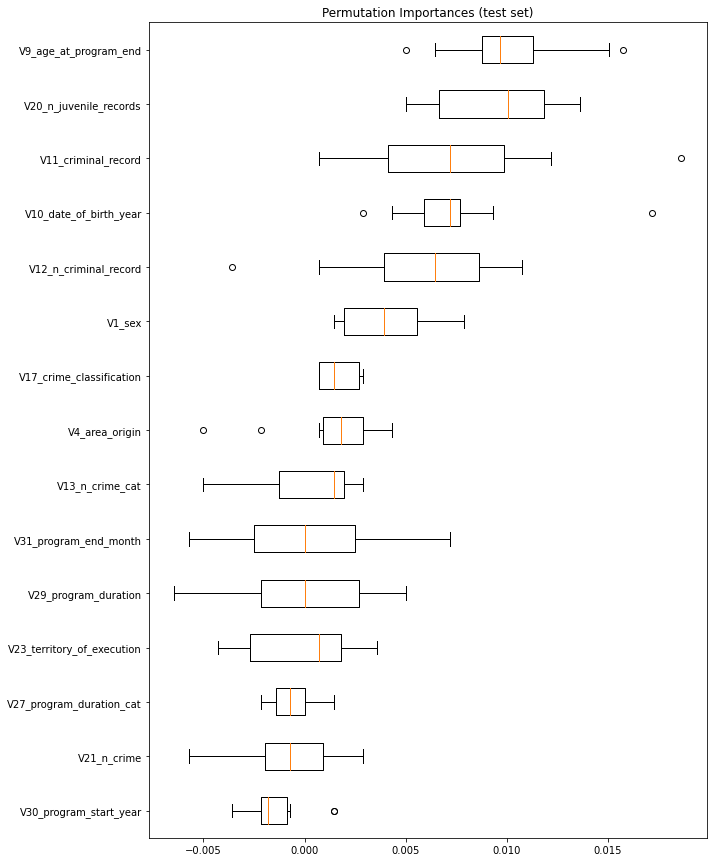

In [69]:
plt.figure(figsize=(10,15))

# plot
sorted_idx = perm.importances_mean.argsort()[-15:]
plt.boxplot(perm.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
plt.title("Permutation Importances (test set)")
plt.show()

In [70]:
top15features = sorted_idx # a better name for later use

In [71]:
# feature importance directly from random forest

pd.DataFrame(zip(X.columns,model.feature_importances_), columns=["attr","importance"]).sort_values("importance", ascending=False).head(20)

,attr,importance
18,V28_days_from_crime_to_program,0.098327
19,V29_program_duration,0.094619
21,V10_date_of_birth_month,0.065316
12,V20_n_juvenile_records,0.063661
23,V22_main_crime_date_month,0.060133
11,V19_committed_crime,0.059670
26,V31_program_end_month,0.055664
25,V30_program_start_month,0.055165
4,V9_age_at_program_end,0.047936
6,V12_n_criminal_record,0.045162


In [72]:
df.iloc[:,sorted_idx]

,V22_main_crime_date_year,V20_n_juvenile_records,V26_finished_measure_grouped,V21_n_crime,V28_days_from_crime_to_program,V30_program_start_year,V12_n_criminal_record,V1_sex,V16_violent_crime,id,V11_criminal_record,V29_program_duration,V9_age_at_program_end,V19_committed_crime,V8_age
0,2008,1.0,2,4,587.0,2010,1,1,1,691,1,132,17,15,15
1,2009,1.0,2,2,107.0,2009,1,0,1,956,1,258,15,15,14
2,2009,4.0,2,3,135.0,2010,2,1,1,2560,1,85,16,15,15
3,2009,7.0,2,2,176.0,2009,3,1,1,2018,1,271,15,15,14
4,2008,6.0,2,3,261.0,2009,3,1,1,1650,1,533,20,15,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4647,2009,0.0,3,1,91.0,2009,0,1,0,268,0,125,17,21,16
4648,2010,0.0,3,2,39.0,2010,0,1,0,999,0,41,18,21,17
4649,2010,0.0,3,1,94.0,2010,0,1,0,3995,0,38,18,21,17
4650,2009,0.0,3,1,86.0,2009,0,1,0,4018,0,119,17,21,17


In [73]:
# misc filters
filter_is_female_test = X_test.V1_sex_female == 1
filter_is_from_Maghreb = X_test.V4_area_origin_Maghreb == 1
filter_is_from_Europe = X_test.V4_area_origin_Europe == 1
filter_is_from_Spain = X_test.V4_area_origin_Spain == 1
# is_from_other is interesting but lacks datapoint
filter_is_from_south_america = (X_test.V4_area_origin_Europe == 0) & \
    (X_test.V4_area_origin_Spain == 0) & \
    (X_test.V4_area_origin_Other == 0) & \
    (X_test.V4_area_origin_Maghreb== 0) 


KeyboardInterrupt



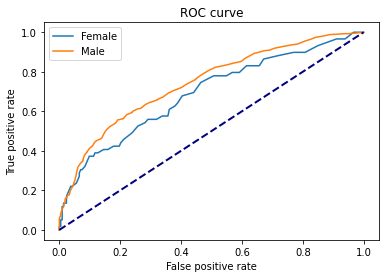

In [ ]:
legend1 = "Female"
filter1 = (X_test.V31_program_end_month == 1)
legend2 = "Male"
filter2 = X_test.V1_sex == 1

y_pred_proba_1 = pd.DataFrame(model.predict_proba(X_test[filter1]))[1]
y_pred_proba_2 = pd.DataFrame(model.predict_proba(X_test[filter2]))[1]

plot_roc_curves(y_test[filter1], y_pred_proba_1, legend=legend1)
plot_roc_curves(y_test[filter2], y_pred_proba_2, legend=legend2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

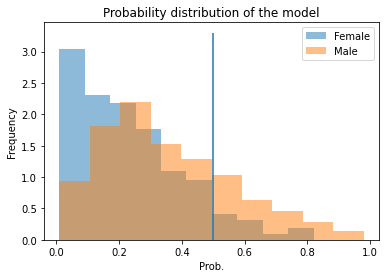

In [ ]:
y_pred_proba_1.plot(kind="hist", alpha=0.5, label=legend1, density=True)
y_pred_proba_2.plot(kind="hist", alpha=0.5, label=legend2, density=True)
plt.xlabel("Prob.")
plt.vlines(0.5,0,3.3)
plt.legend()
plt.title("Probability distribution of the model")
plt.show()

In [ ]:
# calculate tpr and fpr for different thresholds
def tpr_fpr(y_pred_proba, y_test, th):
    y_pred = y_pred_proba > th
    # true positive rate
    tp = ((y_pred == y_test.values) & (y_pred == 1)).sum()
    p = y_test.sum()

    # false positive rate
    fp = ((y_pred != y_test.values) & (y_pred == 1)).sum()
    n = (y_test==0).sum()
    
    return (tp / p), (fp / n)


In [ ]:
for name in X.columns[top15features]:
    print(name, len(X[class_].unique()) > 15)

V30_program_start_year False
V24_finished_program False
V17_crime_classification False
V31_program_end_month False
V19_committed_crime False
V8_age False
V29_program_duration False
V15_main_crime_cat False
V30_program_start_month False
V12_n_criminal_record False
V4_area_origin False
V1_sex False
V10_date_of_birth_year False
V20_n_juvenile_records False
V9_age_at_program_end False


In [ ]:
X[class_].unique()

/Users/oas/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


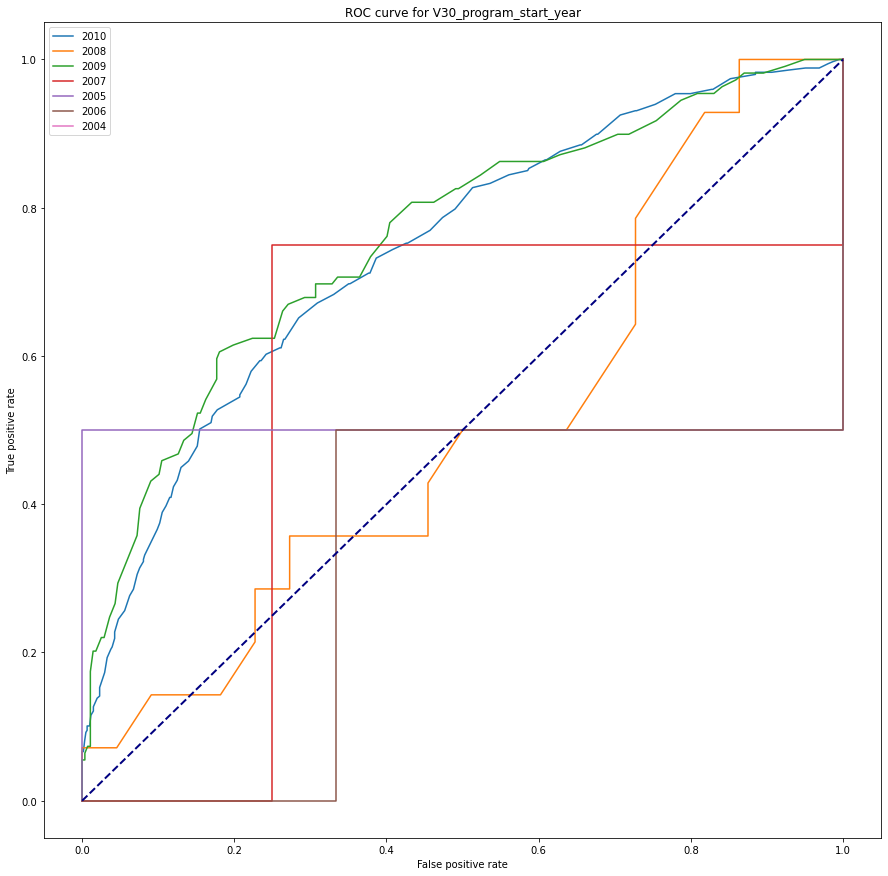

/Users/oas/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/oas/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/oas/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/oas/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/Users/oas/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  wa

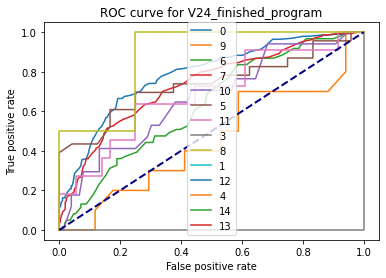

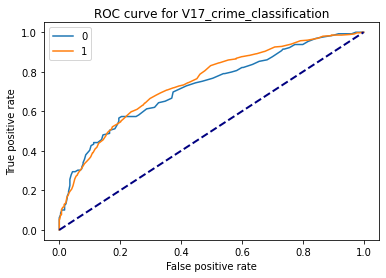

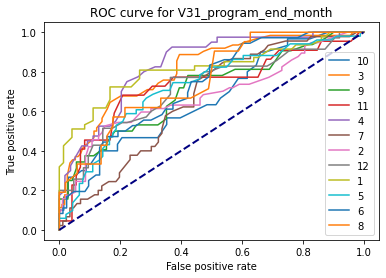

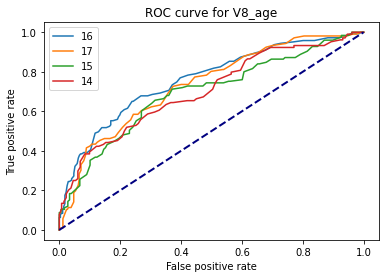

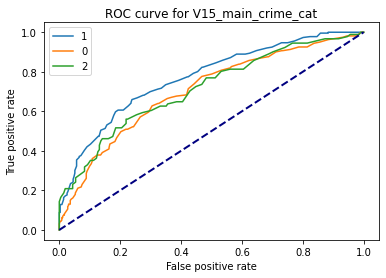

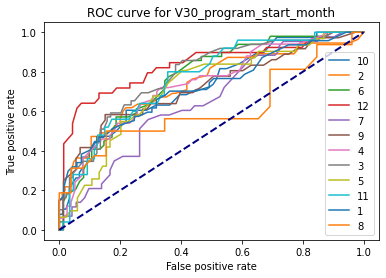

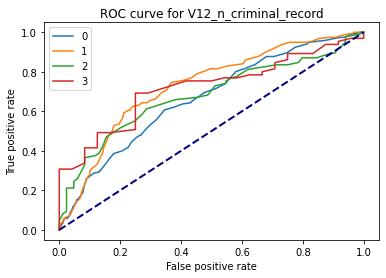

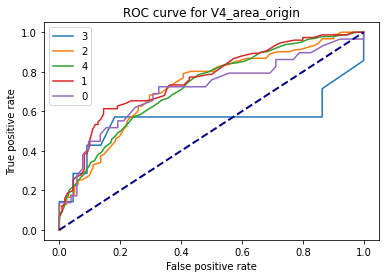

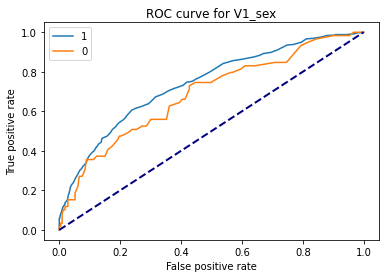

/Users/oas/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/oas/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/oas/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


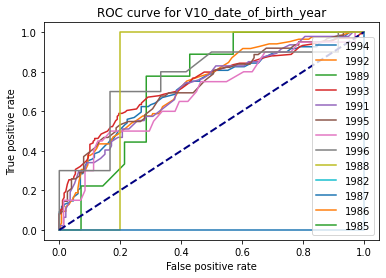

/Users/oas/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/oas/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/oas/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


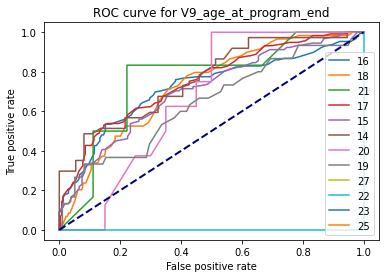

In [ ]:
plt.figure(figsize=(15,15))
for class_ in X.columns[top15features]:
    if len(X[class_].unique()) > 15: continue
    plot_roc_curves_class(X_test, y_test, model, class_)
    plt.show()

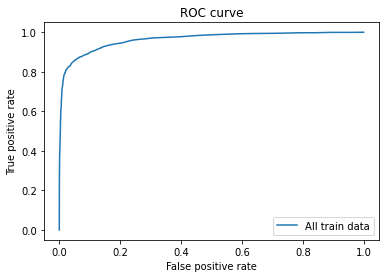

In [ ]:
plot_roc_curves(y.values, pd.DataFrame(model.predict_proba(X))[1], legend="All train data")

(830, 3822)

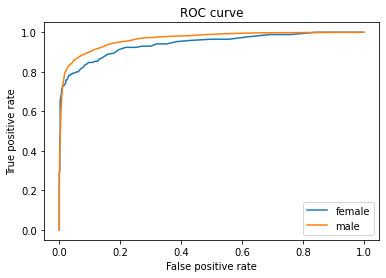

In [ ]:
legend1_all = "female"
filter1_all = X.V1_sex_female == 1
legend2_all = "male"
filter2_all = X.V1_sex_male == 1
plot_roc_curves(y[filter1_all], pd.DataFrame(model.predict_proba(X[filter1_all]))[1], legend=legend1_all)
plot_roc_curves(y[filter2_all], pd.DataFrame(model.predict_proba(X[filter2_all]))[1], legend=legend2_all)
filter1_all.sum(), filter2_all.sum()

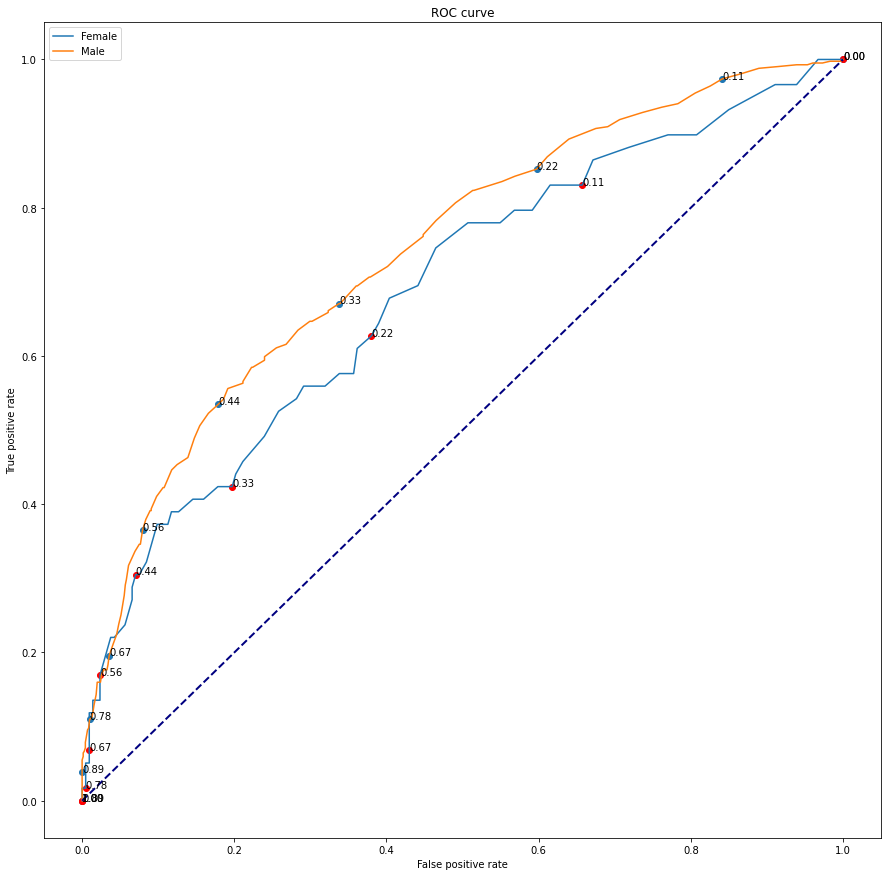

In [ ]:
plt.figure(figsize=(15,15))

plot_roc_curves(y_test[filter1], y_pred_proba_1, legend=legend1)
plot_roc_curves(y_test[filter2], y_pred_proba_2, legend=legend2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

values = [tpr_fpr(y_pred_proba_2, y_test[filter2], th) for th in np.linspace(1,0,10)]
tprs = [val[0] for val in values]
fpsr = [val[1] for val in values]
plt.scatter(fpsr, tprs)
for i, txt in enumerate(np.linspace(1,0,10)):
    plt.annotate(f"{txt:.2f}", (fpsr[i], tprs[i]))

values = [tpr_fpr(y_pred_proba_1, y_test[filter1], th) for th in np.linspace(1,0,10)]
tprs = [val[0] for val in values]
fpsr = [val[1] for val in values]
plt.scatter(fpsr, tprs, color="red")

# annotate each scatter point
for i, txt in enumerate(np.linspace(1,0,10)):
    plt.annotate(f"{txt:.2f}", (fpsr[i], tprs[i]))

plt.show()

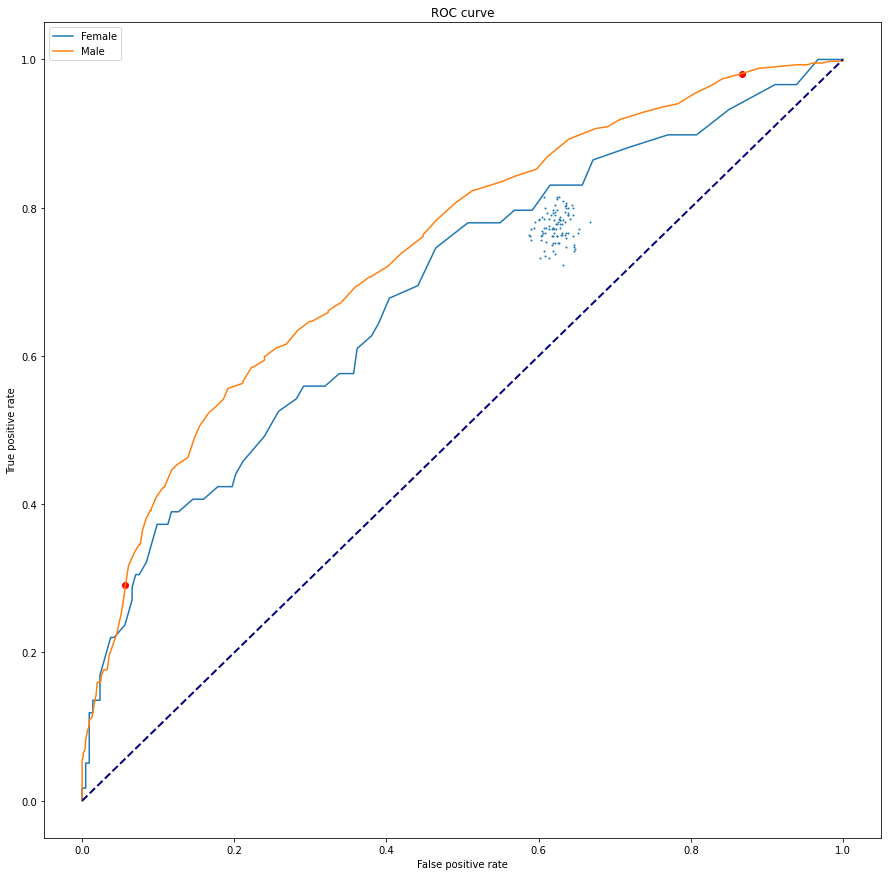

In [ ]:
plt.figure(figsize=(15,15))

plot_roc_curves(y_test[filter1], y_pred_proba_1, legend=legend1)
plot_roc_curves(y_test[filter2], y_pred_proba_2, legend=legend2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

tpr,fpr = tpr_fpr(y_pred_proba_2, y_test[filter2], 0.6)
plt.scatter(fpr, tpr, color="r")
tpr,fpr = tpr_fpr(y_pred_proba_2, y_test[filter2], 0.1)
plt.scatter(fpr, tpr, color="r")

values = []
th = 0.7
for _ in range(100):
    ths = [0.1 if r < th else 0.6 for r in np.random.random(y_pred_proba_2.shape[0])]
    values.append( tpr_fpr(y_pred_proba_2, y_test[filter2], ths))
tprs = [val[0] for val in values]
fpsr = [val[1] for val in values]
plt.scatter(fpsr, tprs, s=1)

plt.show() #TODO: make use of the lower half of the graph, plot the equivelent plot for the two metrics from the course

Please design your own criteria for diagnosing the three main definitions
of fairness: Independence, Separation and Sufficiency. Use your criteria to
perform a diagnostic test of your algorithm with respect to sensitive groups
such as race and/or gender. Please describe your designed diagnostic
criteria, as well as the results of your test. The rest of the project will be
most interesting if you have picked a classifier where you observe unfairness
at this point.

In [ ]:
# ### Attributes to test
# Sex: \
# 'V1_sex_female' \
# 'V1_sex_male' 

# Origin: \
# 'V4_area_origin_Europe' \
# V4_area_origin_Latin America'\
# 'V4_area_origin_Maghreb'\
# 'V4_area_origin_Other'

# Age:\
# 'V8_age_14' \
# 'V8_age_15' \
# 'V8_age_16' \
# 'V8_age_17' 



## Independence

In [ ]:
# test independence of the model
def test_independence(model,X, a, b, allowed_err=0):
    # y is the target variable
    # X is the feature matrix
    # a is the column for the first group
    # b is the column for the second group
    # for both grouqps a and b, the values are 0 or 1 (one-hot encoding)

    # create two groups
    X_a = X[X[a]==1]
    X_b = X[X[b]==1]

    # check prediction for group a and b
    y_pred_a = model.predict(X_a)
    y_pred_b = model.predict(X_b)

    # calculate p(y_pred=1|A=a) and p(y_pred=1|A=b)
    p_a = np.mean(y_pred_a)
    p_b = np.mean(y_pred_b)

    #print results
    print(f"p(y_pred=1|A={a}) = {p_a:.3f}")
    print(f"p(y_pred=1|A={b}) = {p_b:.3f}")

    if abs(p_a - p_b) <= allowed_err:
        print("The model fulfills independence")
    else:
        print("The model does not fulfill independence")

    return p_a, p_b


In [ ]:
test_independence(model,X, "V1_sex_male", "V1_sex_female", allowed_err=0.05)

p(y_pred=1|A=V1_sex_male) = 0.333
p(y_pred=1|A=V1_sex_female) = 0.159
The model does not fulfill independence


(0.3333333333333333, 0.15903614457831325)

comment: the model discriminates males

In [ ]:
# test seperation of the model
def test_seperation(model,X, y, a, b, allowed_err=0):
    # y is the target variable
    # X is the feature matrix
    # a is the column for the first group
    # b is the column for the second group
    # for both grouqps a and b, the values are 0 or 1 (one-hot encoding)

    # create four groups
    X_1_a = X[(X[a]==1) & (y==1)]
    X_1_b = X[(X[b]==1) & (y==1)]
    X_0_a = X[(X[a]==1) & (y==0)]
    X_0_b = X[(X[b]==1) & (y==0)]

    # check prediction all groups
    y_pred_1_a = model.predict(X_1_a)
    y_pred_1_b = model.predict(X_1_b)
    y_pred_0_a = model.predict(X_0_a)
    y_pred_0_b = model.predict(X_0_b)

    # calculate p(y_pred=1|Y=1, A=a) and p(y_pred=1|Y=1, A=b) etc
    p_1_a = np.mean(y_pred_1_a)
    p_1_b = np.mean(y_pred_1_b)
    p_0_a = np.mean(y_pred_0_a)
    p_0_b = np.mean(y_pred_0_b)

    #print results
    print(f"p(y_pred=1|Y=1, A={a}) = {p_1_a:.3f}")
    print(f"p(y_pred=1|Y=1, A={b}) = {p_1_b:.3f}")
    print(f"p(y_pred=1|Y=0, A={a}) = {p_0_a:.3f}")
    print(f"p(y_pred=1|Y=0, A={b}) = {p_0_b:.3f}")

    if abs(p_1_a - p_1_b) <= allowed_err and abs(p_0_a - p_0_b) <= allowed_err:
        print("The model fulfills seperation")
    else:
        print("The model does not fulfill seperation")

    return p_1_a, p_1_b, p_0_a, p_0_b

In [ ]:
test_seperation(model,X,y, "V1_sex_male", "V1_sex_female", allowed_err=0.05)

p(y_pred=1|Y=1, A=V1_sex_male) = 0.836
p(y_pred=1|Y=1, A=V1_sex_female) = 0.729
p(y_pred=1|Y=0, A=V1_sex_male) = 0.035
p(y_pred=1|Y=0, A=V1_sex_female) = 0.012
The model does not fulfill seperation


(0.836376404494382,
 0.7294117647058823,
 0.03461217681401168,
 0.012121212121212121)

In [ ]:
_=test_seperation(model,X,y, 'V4_area_origin_Europe', 'V4_area_origin_Latin America')
_=test_seperation(model,X,y, 'V4_area_origin_Maghreb', 'V4_area_origin_Other')

p(y_pred=1|Y=1, A=V4_area_origin_Europe) = 0.855
p(y_pred=1|Y=1, A=V4_area_origin_Latin America) = 0.857
p(y_pred=1|Y=0, A=V4_area_origin_Europe) = 0.056
p(y_pred=1|Y=0, A=V4_area_origin_Latin America) = 0.029
The model does not fulfill seperation
p(y_pred=1|Y=1, A=V4_area_origin_Maghreb) = 0.902
p(y_pred=1|Y=1, A=V4_area_origin_Other) = 0.833
p(y_pred=1|Y=0, A=V4_area_origin_Maghreb) = 0.075
p(y_pred=1|Y=0, A=V4_area_origin_Other) = 0.027
The model does not fulfill seperation


In [ ]:
pred_proba = pd.DataFrame(model.predict_proba(X_test))[1]

In [ ]:
for th in np.linspace(0,1,100):
    pred = pred_proba > th
    

In [ ]:
(pd.DataFrame(model.predict_proba(X_test))[1] > 0.5).sum()

291

In [ ]:
y_test.replace(1,True).replace(0,False)

4183    False
2362     True
1390    False
4143    False
2075    False
        ...  
1716    False
1082    False
234      True
941      True
1807    False
Name: V115_RECID2015_recid, Length: 1396, dtype: bool